Cristiano Colpo cristiano.colpo@studenti.unipd.it 2017898


Mattia Sandri mattia.sandri.1@studenti.unipd.it 2021425

# Final project MANAGEMENT AND ANALYSIS OF PHYSICS DATASET 
## Anomaly detection and Predictive maintence for industrial devices

### Anomaly Detection 2

Identify some possible correlations between the percentage of device loading and the external temperature

In [4]:
from dask.distributed import Client
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [5]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.77 GiB
Comm: tcp://127.0.0.1:34393,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.77 GiB
Comm: tcp://127.0.0.1:34385,Total threads: 1
Dashboard: http://127.0.0.1:45907/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:33785,


![Dashboard](img/DaskDashboard.png)

In [3]:
df = dd.read_csv("dataset.csv")
df['when']=dd.to_datetime(df.when,unit='ms')

In [4]:
data = df[(df["metric"]=='S46')|(df["metric"]=='S125')|(df["metric"]=='S181')|(df["metric"]=='P17')|(df["metric"]=='P7')|(df["metric"]=='P9')|(df["metric"]=='S41')]
data = data.set_index("when").groupby("metric").apply(lambda df: df.resample("1min").mean().dropna()).compute()

<ipython-input-4-f46ae1e39650>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  data = data.set_index("when").groupby("metric").apply(lambda df: df.resample("1min").mean().dropna()).compute()


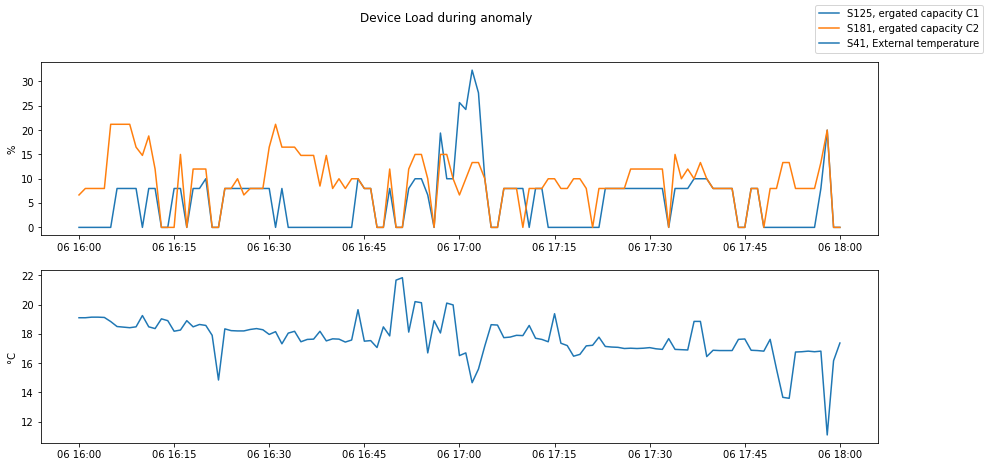

In [5]:
fig, axs = plt.subplots(2, figsize=(15,7))
fig.suptitle('Device Load during anomaly')
axs[0].plot(data.loc['S125']["2020-11-06 16:00:00":"2020-11-06 18:00:00"],label="S125, ergated capacity C1")
axs[0].plot(data.loc['S181']["2020-11-06 16:00:00":"2020-11-06 18:00:00"], label="S181, ergated capacity C2")
axs[0].set_ylabel("%")
axs[1].plot(data.loc['S41']["2020-11-06 16:00:00":"2020-11-06 18:00:00"]/10, label="S41, External temperature")
axs[1].set_ylabel("°C")
fig.legend()

\
The motors seems to turn on when the temperature is getting low. To further show the link between this values, we can calculate the correlation:

In [6]:
data.loc['S125'].value.corr(data.loc['S41'].value)

-0.2329938919442654

In [7]:
data.loc['S181'].value.corr(data.loc['S41'].value)

-0.09021069808206268

\
There is inverse correlation, meaning that when the temperature goes low, the percentage of load goes up.
\
\
Now let's investigate the correlation with other variables, by finding the anomalies ("salient points") as in Part 1:

In [8]:
motors_data = df[(df["metric"] == "S117")|(df["metric"] =="S118")|(df["metric"] =="S169")|(df["metric"] =="S170")]
groupby = motors_data.set_index("when").groupby("metric").apply(lambda df: df.resample("1min").max().dropna(),
                                                               meta={"hwid":"object",
                                                                     "metric":"object",
                                                                     "value":"object"
                                                                    }
                                                               ).compute()

In [9]:
groupby.index = groupby.index.droplevel(0)

In [10]:
changesOfState = dd.from_pandas(groupby, npartitions=3)

In [11]:
changesOfState = changesOfState.persist()

In [12]:
changesOfState_groupby = changesOfState.groupby("metric").apply(lambda df: df.assign(diff=df.value.diff(1)),
                                                               meta={"hwid":"object",
                                                                     "metric":"object",
                                                                     "value":"object",
                                                                     "diff":"object"
                                                                    }
                                                               ).compute()

In [13]:
changesOfState_s117 = changesOfState_groupby.loc["S117",:]["diff"].abs().dropna()
changesOfState_s118 = changesOfState_groupby.loc["S118",:]["diff"].abs().dropna()
changesOfState_s169 = changesOfState_groupby.loc["S169",:]["diff"].abs().dropna()
changesOfState_s170 = changesOfState_groupby.loc["S170",:]["diff"].abs().dropna()

In [14]:
NumberOfChangesOfState_s117 = changesOfState_s117.resample('1h').sum()
NumberOfChangesOfState_s118 = changesOfState_s118.resample('1h').sum()
NumberOfChangesOfState_s169 = changesOfState_s169.resample('1h').sum()
NumberOfChangesOfState_s170 = changesOfState_s170.resample('1h').sum()

In [15]:
salientPoints_s170 = NumberOfChangesOfState_s170[NumberOfChangesOfState_s170 > NumberOfChangesOfState_s170.mean()+3*NumberOfChangesOfState_s170.std()].dropna()
salientPoints_s169 = NumberOfChangesOfState_s169[NumberOfChangesOfState_s169 > NumberOfChangesOfState_s169.mean()+3*NumberOfChangesOfState_s169.std()].dropna()
salientPoints_s117 = NumberOfChangesOfState_s117[NumberOfChangesOfState_s117 > NumberOfChangesOfState_s117.mean()+3*NumberOfChangesOfState_s117.std()].dropna()
salientPoints_s118 = NumberOfChangesOfState_s118[NumberOfChangesOfState_s118 > NumberOfChangesOfState_s118.mean()+3*NumberOfChangesOfState_s118.std()].dropna()

In [16]:
salientPoints = pd.DataFrame(pd.concat([salientPoints_s117, salientPoints_s118, salientPoints_s169, salientPoints_s170])).sort_values(by="when")

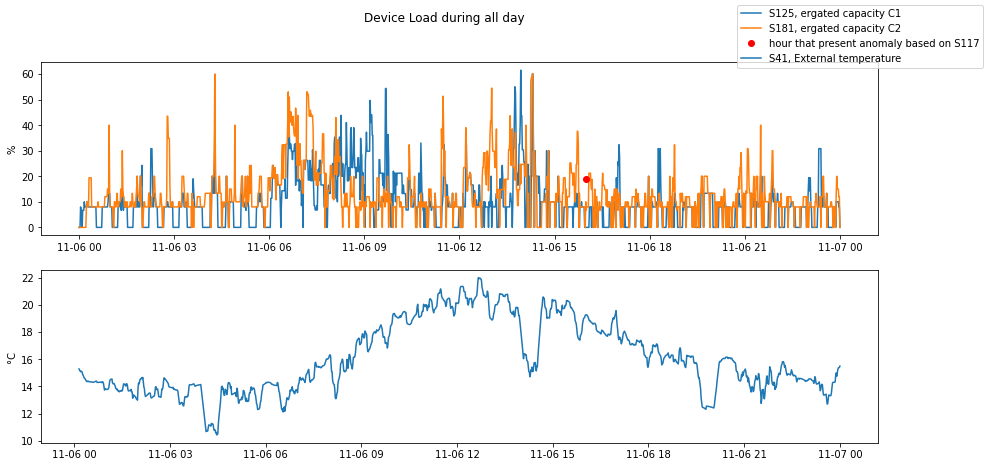

In [17]:
fig, axs = plt.subplots(2, figsize=(15,7))
fig.suptitle('Device Load during all day ')
axs[0].plot(data.loc['S125']["2020-11-06 0:00:00":"2020-11-07 00:00:00"],label="S125, ergated capacity C1")
axs[0].plot(data.loc['S181']["2020-11-06 0:00:00":"2020-11-07 00:00:00"], label="S181, ergated capacity C2")
axs[0].plot(salientPoints_s117["2020-11-06 0:00:00":"2020-11-07 00:00:00"],"ro" ,label="hour that present anomaly based on S117")

axs[0].set_ylabel("%")
axs[1].plot((data.loc['S41']["2020-11-06 0:00:00":"2020-11-07 0:00:00"]/10).rolling(window=10).mean(), label="S41, External temperature")
axs[1].set_ylabel("°C")
fig.legend()

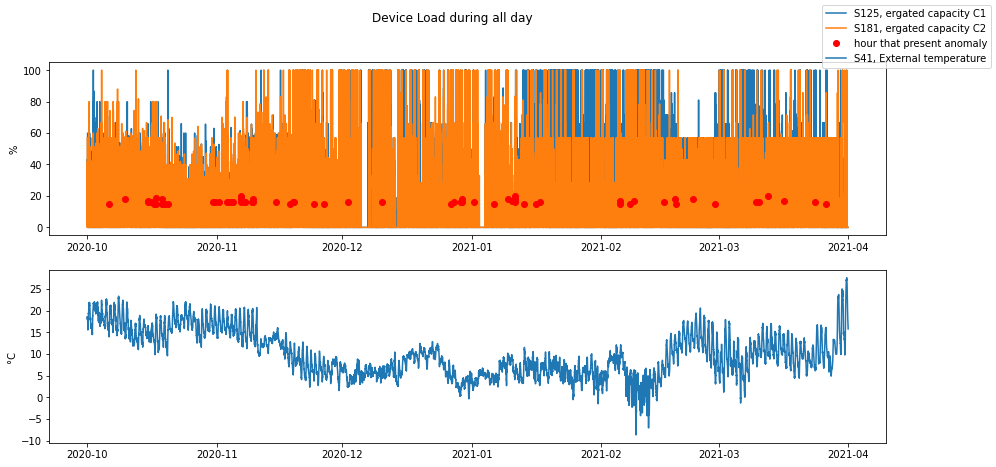

In [18]:
fig, axs = plt.subplots(2, figsize=(15,7))
fig.suptitle('Device Load during all day ')
axs[0].plot(data.loc['S125'].rolling(window=1).mean(),label="S125, ergated capacity C1")
axs[0].plot(data.loc['S181'].rolling(window=1).mean(), label="S181, ergated capacity C2")
axs[0].plot(salientPoints,"ro" ,label="hour that present anomaly")

axs[0].set_ylabel("%")
axs[1].plot((data.loc['S41']/10).rolling(window=100).mean(), label="S41, External temperature")
axs[1].set_ylabel("°C")
fig.legend()

This graph further show the correlation between a low external temperature and a high percentage of load on the engines

In [19]:
S125 = data.loc['S125']
S125_full_load = S125[S125["value"]==100].resample("1h").max().dropna()
#intersection between dates with anomalies and dates with device at full load 
S125_full_load.loc[(S125_full_load.index & salientPoints.index)]

<ipython-input-19-c834db75506f>:4: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  S125_full_load.loc[(S125_full_load.index & salientPoints.index)]


,value
when,
2020-12-10 10:00:00,100.0
2020-12-29 07:00:00,100.0
2021-01-16 06:00:00,100.0
2021-02-05 10:00:00,100.0


In [20]:
S181 = data.loc['S181']
S181_full_load = S181[S181["value"]==100].resample("1h").max().dropna()
#intersection between dates with anomalies and dates with device at full load 
S181_full_load.loc[(S181_full_load.index & salientPoints.index)]

<ipython-input-20-67fdc5f7f6d9>:4: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  S181_full_load.loc[(S181_full_load.index & salientPoints.index)]


,value
when,
2020-12-29 07:00:00,100.0
2021-01-09 13:00:00,100.0
2021-02-05 08:00:00,100.0
